Loaded 110 puzzles.
[1/110] 0.jpg → Tile Accuracy: 100.00%


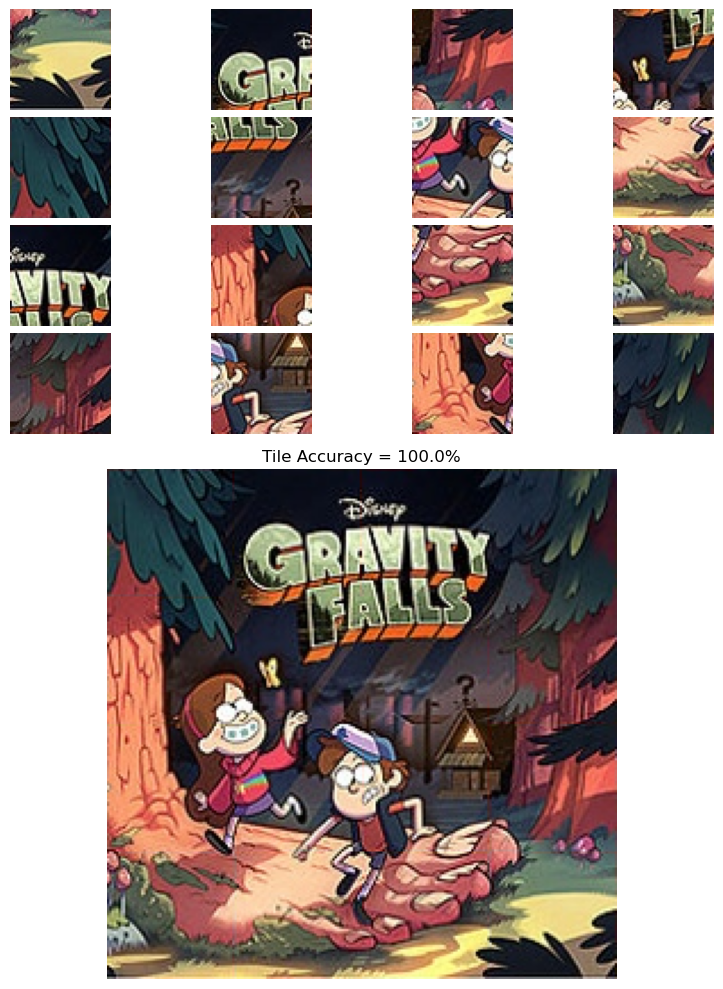

[2/110] 1.jpg → Tile Accuracy: 100.00%
[3/110] 2.jpg → Tile Accuracy: 100.00%
[4/110] 3.jpg → Tile Accuracy: 0.00%
[5/110] 4.jpg → Tile Accuracy: 0.00%
[6/110] 5.jpg → Tile Accuracy: 0.00%
[7/110] 6.jpg → Tile Accuracy: 0.00%
[8/110] 7.jpg → Tile Accuracy: 100.00%
[9/110] 8.jpg → Tile Accuracy: 0.00%
[10/110] 9.jpg → Tile Accuracy: 100.00%
[11/110] 10.jpg → Tile Accuracy: 0.00%
[12/110] 11.jpg → Tile Accuracy: 100.00%
[13/110] 12.jpg → Tile Accuracy: 100.00%
[14/110] 13.jpg → Tile Accuracy: 100.00%
[15/110] 14.jpg → Tile Accuracy: 87.50%
[16/110] 15.jpg → Tile Accuracy: 100.00%
[17/110] 16.jpg → Tile Accuracy: 81.25%
[18/110] 17.jpg → Tile Accuracy: 100.00%
[19/110] 18.jpg → Tile Accuracy: 0.00%
[20/110] 19.jpg → Tile Accuracy: 100.00%
[21/110] 20.jpg → Tile Accuracy: 100.00%
[22/110] 21.jpg → Tile Accuracy: 0.00%
[23/110] 22.jpg → Tile Accuracy: 100.00%
[24/110] 23.jpg → Tile Accuracy: 0.00%
[25/110] 24.jpg → Tile Accuracy: 100.00%
[26/110] 25.jpg → Tile Accuracy: 0.00%
[27/110] 26.jp

In [5]:
# =========================================================
# 1. IMPORTS & PATHS
# =========================================================
import cv2
import numpy as np
import glob
import os
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.metrics import structural_similarity as ssim


PUZZLE_DIR = r"C:\Term 5\image_project\OneDrive_2025-11-26\Jigsaw Puzzle Dataset\Gravity Falls\puzzle_4x4"
GT_DIR     = r"C:\Term 5\image_project\OneDrive_2025-11-26\Jigsaw Puzzle Dataset\Gravity Falls\correct"


# =========================================================
# 2. IMAGE SLICING
# =========================================================
def cut_into_tiles(img):
    h, w, _ = img.shape
    th, tw = h // 4, w // 4
    return [
        img[r*th:(r+1)*th, c*tw:(c+1)*tw]
        for r in range(4) for c in range(4)
    ]


# =========================================================
# 3. EDGE COST (CLASSICAL SSD)
# =========================================================
def edge_cost(edge_a, edge_b):
    diff = edge_a.astype(np.float32) - edge_b.astype(np.float32)
    return np.mean(diff * diff)


# =========================================================
# 4. GREEDY SOLVER (STABLE BASELINE)
# =========================================================
def assemble_with_anchor(tiles, anchor_idx):
    SIZE = 4
    grid = [[None]*SIZE for _ in range(SIZE)]
    used = set()

    grid[0][0] = anchor_idx
    used.add(anchor_idx)

    for r in range(SIZE):
        for c in range(SIZE):
            if r == 0 and c == 0:
                continue

            best_idx = None
            best_score = float("inf")

            for i in range(len(tiles)):
                if i in used:
                    continue

                score = 0
                if c > 0:
                    left_tile = tiles[grid[r][c-1]]
                    score += edge_cost(left_tile[:, -1, :], tiles[i][:, 0, :])

                if r > 0:
                    top_tile = tiles[grid[r-1][c]]
                    score += edge_cost(top_tile[-1, :, :], tiles[i][0, :, :])

                if score < best_score:
                    best_score = score
                    best_idx = i

            grid[r][c] = best_idx
            used.add(best_idx)

    return grid


def solve_puzzle(tiles):
    best_grid = None
    best_cost = float("inf")

    for i in range(len(tiles)):
        grid = assemble_with_anchor(tiles, i)
        cost = 0

        for r in range(4):
            for c in range(4):
                if c > 0:
                    cost += edge_cost(
                        tiles[grid[r][c-1]][:, -1, :],
                        tiles[grid[r][c]][:, 0, :]
                    )
                if r > 0:
                    cost += edge_cost(
                        tiles[grid[r-1][c]][-1, :, :],
                        tiles[grid[r][c]][0, :, :]
                    )

        if cost < best_cost:
            best_cost = cost
            best_grid = grid

    return best_grid


# =========================================================
# 5. RECONSTRUCTION
# =========================================================
def reconstruct(grid, tiles):
    h, w, _ = tiles[0].shape
    out = np.zeros((4*h, 4*w, 3), dtype=np.uint8)
    for r in range(4):
        for c in range(4):
            out[r*h:(r+1)*h, c*w:(c+1)*w] = tiles[grid[r][c]]
    return out


# =========================================================
# 6. TILE-LEVEL ACCURACY
# =========================================================
def compute_tile_accuracy(reconstructed, puzzle_name):
    base = os.path.splitext(puzzle_name)[0]
    gt_path = glob.glob(os.path.join(GT_DIR, f"{base}.*"))[0]
    gt = cv2.cvtColor(cv2.imread(gt_path), cv2.COLOR_BGR2RGB)

    h, w, _ = gt.shape
    reconstructed = cv2.resize(reconstructed, (w, h))

    th, tw = h // 4, w // 4
    correct_tiles = 0

    for r in range(4):
        for c in range(4):
            gt_tile = gt[r*th:(r+1)*th, c*tw:(c+1)*tw]
            rc_tile = reconstructed[r*th:(r+1)*th, c*tw:(c+1)*tw]

            score, _ = ssim(
                cv2.cvtColor(gt_tile, cv2.COLOR_RGB2GRAY),
                cv2.cvtColor(rc_tile, cv2.COLOR_RGB2GRAY),
                full=True
            )

            if score > 0.90:
                correct_tiles += 1

    accuracy = (correct_tiles / 16) * 100
    return accuracy, correct_tiles


# =========================================================
# 7. VISUALIZATION (OPTIONAL)
# =========================================================
def visualize_solution(tiles, reconstructed, title):
    fig = plt.figure(figsize=(8, 10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1.2])

    grid = gridspec.GridSpecFromSubplotSpec(4, 4, subplot_spec=gs[0])
    for i in range(16):
        ax = fig.add_subplot(grid[i // 4, i % 4])
        ax.imshow(tiles[i])
        ax.axis("off")

    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(reconstructed)
    ax2.set_title(title)
    ax2.axis("off")

    plt.tight_layout()
    plt.show()


# =========================================================
# 8. MAIN PIPELINE
# =========================================================
files = sorted(
    glob.glob(os.path.join(PUZZLE_DIR, "*.jpg")),
    key=lambda x: int(os.path.basename(x).split(".")[0])
)

results = []
total_correct_tiles = 0
total_tiles = 0
correct_images = 0

print(f"Loaded {len(files)} puzzles.")

for i, f in enumerate(files):
    img = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
    tiles = cut_into_tiles(img)

    random.seed(i)
    random.shuffle(tiles)

    grid = solve_puzzle(tiles)
    reconstructed = reconstruct(grid, tiles)

    acc, correct = compute_tile_accuracy(reconstructed, os.path.basename(f))
    results.append(acc)

    total_correct_tiles += correct
    total_tiles += 16

    # IMAGE-LEVEL CORRECTNESS
    if correct == 16:
        correct_images += 1

    print(f"[{i+1}/{len(files)}] {os.path.basename(f)} → Tile Accuracy: {acc:.2f}%")

    if i == 0:
        visualize_solution(tiles, reconstructed, f"Tile Accuracy = {acc:.1f}%")


# =========================================================
# 9. FINAL SUMMARY
# =========================================================
total_accuracy = (total_correct_tiles / total_tiles) * 100
image_accuracy = (correct_images / len(files)) * 100

print("\n" + "="*60)
print(f"AVERAGE TILE ACCURACY : {np.mean(results):.2f}%")
print(f"TOTAL TILE ACCURACY   : {total_accuracy:.2f}%")
print(f"CORRECT TILES         : {total_correct_tiles} / {total_tiles}")
print(f"CORRECT IMAGES        : {correct_images} / {len(files)}")
print(f"IMAGE ACCURACY        : {image_accuracy:.2f}%")
print(f"MIN / MAX             : {np.min(results):.2f}% / {np.max(results):.2f}%")
print(f"STD DEV               : {np.std(results):.2f}%")
print("="*60)